### This script should produce the plot of the experimental and simulated growth comparison from data given by [Carnicer et al. 2012](https://microbialcellfactories.biomedcentral.com/articles/10.1186/1475-2859-11-83/tables/1)

In [2]:
# imports
import cobra
import yaml
import numpy as np # plotting
import matplotlib.pyplot as plt # plotting
from cobra.flux_analysis import pfba
from cobra.medium import minimal_medium

import sys # append path


sys.path.append('../scripts/')
import helperFunction as hf
from importlib import reload
reload(hf)

# config
config_name = 'model_config'
config_path = f'../config/{config_name}.yaml'

# load config
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
_plotting = True
# global variables (experimental data + maintenance)
experiment_number = 3 # set 3 to only simulate wild-type and ignore recombinant strain
glucose_uptake = [1.00, 1.28, 1.72, 1.01, 1.37, 1.56]
oxygen_uptake = [2.35, 2.01, 2.01, 2.44, 1.99, 1.81]
ppa_experimental_growth = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
ppa_co2_prod = [2.43, 2.55, 3.21, 2.52, 2.68, 2.94]
ppa_ethanol_prod = [1000, 0.31, 0.84, 1000, 0.41, 0.83]
# ppa_arabitol_prod = [xxxxx] # not used according to iMT1026v1 supplementary

_ppa_maintenance = 2.9 # mmol/gDW/h

_growth_conditions = {'experimental': ppa_experimental_growth[:3]}
_co2_productions = {'experimental': ppa_co2_prod[:3]}
_condition_names = ['normoxic', 'O2-limited', 'hypoxic']
_without_iMT1026v1 = True # because iTM1026v1 has no meaningful results

# helpful functions:
# def plot_multiple_conditions(value_dict, conditions, title, y_label, min_value = 0, max_value = 0.3):
#     '''Plot the for each condition of multiple models the given values (in a dict of value lists) + list of conditions
#     e.g. value_dict = {'iYali4_model': [0.0036, 0.0045],...}
#     @params: conditions: list of conditions
#     @trick: (is extendable) is able to plot conditions for different models'''
#     # get min and max values of dict of lists
#     # min_value = max(0, min([sublist[-1] for sublist in list(value_dict.values())]))
#     # max_value = max([sublist[-1] for sublist in list(value_dict.values())])

#     x = np.arange(len(conditions))  # the label locations
#     width = 0.1  # the width of the bars
#     multiplier = 0
#     fig, ax = plt.subplots(layout='constrained')

#     for attribute, measurement in value_dict.items():
#         offset = width * multiplier
#         rects = ax.bar(x + offset, measurement, width, label=attribute.split('_')[0])
#         # ax.bar_label(rects, padding=3)
#         multiplier += 1

#     # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.set_ylabel(y_label)
#     ax.set_title(title)
#     ax.set_xticks(x + width, conditions)
#     ax.legend(loc='upper left', ncol=3)
#     ax.set_ylim(min_value - 0.1 * (abs(min_value)), max_value + 0.1 * abs(max_value + 1)) # + 1 because of < 1 values

#     plt.show()

## iLC915

In [3]:
# load iLC915
iLC915_model = cobra.io.read_sbml_model(config['models']['ppaiLC915'])
# all relevant reactions:
iLC915_biomass_reaction = 'r1133' # biomass
iLC915_glu_ex_rxn = 'r1145' # glucose uptake
iLC915_fructose_ex_rxn = 'r1144' # fructose uptake
iLC915_glycerol_ex_rxn = 'r1148' # glycerol uptake
iLC915_o2_ex_rxn = 'r1160' # O2
iLC915_arabitol_ex_rxn = 'r1128' # Arabitol/arabinitol
iLC915_ethanol_ex_rxn = 'r1141' # ethanol
iLC915_maintenance = 'r1188' # maintenance 2.9 in iMT1026v3 (0 in iLC915)

In [4]:
# prepare iLC915: needed because of internal cycles and active reactions
# lower and upper bounds of several reactions should be set to zero according to supplementary material of 
constraints_2_zero = ['r66','r910','r1104','r239','r111','r106','r490','r791','r243','r252','r253','r307','r308','r404','r405','r1320','r639','r640','r641','r642','r649','r650','r651','r652','r645','r646','r643','r644','r653','r654','r655','r656','r534'] 
for rxn_id in constraints_2_zero:
    rxn = iLC915_model.reactions.get_by_id(rxn_id)
    rxn.bounds = (0,0)
# constraint formulate uptake because of not meaningful results
formulate_uptake = iLC915_model.reactions.get_by_id('r1143')
formulate_uptake.bounds = (0,0)
# important carbon sources
important_carbon = ['r1132','r1137','r1177']

# all carbon containing exchange reactions
carbon_exchange_rxns = ['r1122', 'r1123', 'r1124', 'r1126', 'r1127', 'r1129', 'r1130', 'r1131', 'r1132', 'r1134', 'r1135', 'r1137', 'r1138', 'r1139', 'r1140', 'r1141', 'r1144', 'r1145', 'r1146', 'r1147', 'r1148', 'r1149', 'r1151', 'r1152', 'r1153', 'r1154', 'r1155', 'r1156', 'r1157', 'r1158', 'r1161', 'r1162', 'r1163', 'r1165', 'r1167', 'r1168', 'r1170', 'r1172', 'r1173', 'r1174', 'r1175', 'r1176', 'r1177', 'r1178']

# set all carbon exchange reactions to 0 except important ones
for rxn_id in carbon_exchange_rxns:
    if rxn_id not in important_carbon:
        rxn = iLC915_model.reactions.get_by_id(rxn_id)
        rxn.bounds = (0,0)

In [4]:
# check definition of important rxns 
important_rxns = ['r1133', 'r1141', 'r1145', 'r1144', 'r1148', 'r1160', 'r1137', 'r1188']

for rxn_id in important_rxns:
    rxn = iLC915_model.reactions.get_by_id(rxn_id)
    print(rxn.reactants, rxn.products, rxn.bounds)
    print(rxn_id, rxn.name, hf.formulaWithNames(rxn), 'rxn coefficient: ', rxn.get_coefficient(list(rxn.metabolites.keys())[0]))

[<Metabolite m1226 at 0x21bb7ced760>] [] (0.0, 1000.0)
r1133 Drain of biomass Biomass_ -->  rxn coefficient:  -1.0
[<Metabolite m1218 at 0x21bb7ced5e0>] [] (0, 0)
r1141 Ethanol uptake or drain Ethanol_C2H6O -->  rxn coefficient:  -1.0
[] [<Metabolite m2 at 0x21b8ecb3760>] (0, 0)
r1145 Uptake of alpha-D-Glucose  --> alpha-D-Glucose_C6H12O6 rxn coefficient:  1.0
[] [<Metabolite m1334 at 0x21bb7cfa250>] (0, 0)
r1144 Uptake of beta-D-Fructose  --> beta-D-Fructose_C6H12O6 rxn coefficient:  1.0
[] [<Metabolite m1238 at 0x21bb7ced9a0>] (0, 0)
r1148 uptake of glycerol  --> Glycerol_C3H8O3 rxn coefficient:  1.0
[] [<Metabolite m1232 at 0x21bb7ced880>] (0.0, 1000.0)
r1160 uptake of O2  --> Oxygen_O2 rxn coefficient:  1.0
[<Metabolite m1244 at 0x21bb7cedac0>] [] (0.0, 1000.0)
r1137 Drain of CO2 CO2_CO2 -->  rxn coefficient:  -1.0
[<Metabolite m1 at 0x21b8ecb39a0>, <Metabolite m5 at 0x21b8ecb3790>] [<Metabolite m3 at 0x21b8ecb3730>, <Metabolite m7 at 0x21b8ecb39d0>] (0.0, 1000.0)
r1188 Maintenance

In [8]:
# set glucose uptake to 2.43
glucose_uptake = iLC915_model.reactions.get_by_id('r1145')
glucose_uptake.bounds = (2.43,2.43)

# write this model to sbml
cobra.io.write_sbml_model(iLC915_model, '../data/models/Pichia_pastoris/iLC915/Ppa_iLC915_glucose_2_43.xml')
iLC915_model.summary() # 0.2432 growth rate

Metabolite,Reaction,Flux,C-Number,C-Flux
m2,r1145,2.43,0,0.00%
m1231,r1159,1.402,0,0.00%
m1232,r1160,3.52,0,0.00%
m1233,r1169,0.007449,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.2432,0,0.00%
m1244,r1137,-4.624,0,0.00%
m30,r1150,-8.594,0,0.00%


In [21]:
# read the model
iLC915_model_glu = cobra.io.read_sbml_model('../data/models/Pichia_pastoris/iLC915/Ppa_iLC915_glucose_2_43.xml')
iLC915_model_glu.summary() # 0.2432 growth rate
# check biomass and compare to biomass_C
biomass = iLC915_model_glu.reactions.get_by_id('r1090') # default r1133 alternative: r1090
biomass

iLC915_model_glu.reactions.get_by_id('r1187').summary().to_string()
hf.formulaWithNames(iLC915_model_glu.reactions.get_by_id('r1187'))


'40.7 ATP_C10H16N5O13P3 + 0.002 ATP_C10H16N5O13P3115 + 0.0388 ATP_C10H16N5O13P3117 + 0.0007 ATP_C10H16N5O13P3119 + 0.0007 ATP_C10H16N5O13P3121 + 0.0002 ATP_C10H16N5O13P3123 + 0.33208 ATP_C10H16N5O13P353 + 0.2689 ATP_C10H16N5O13P354 + 0.15382 ATP_C10H16N5O13P356 + 0.19585 ATP_C10H16N5O13P358 + 0.15382 ATP_C10H16N5O13P361 + 0.2689 ATP_C10H16N5O13P363 + 0.040222 ATP_C10H16N5O13P377 + 0.13623 ATP_C10H16N5O13P385 + 0.22237 L-Lysine_C6H14N2O2 + 0.24035 Glycine_C2H5NO2 + 0.20297 L-Valine_C5H11NO2 + 0.24287 L-Leucine_C6H13NO2 + 0.14544 L-Isoleucine_C6H13NO2 + 1.701 1,3-beta-D-Glucan_ + 0.10532 L-Phenylalanine_C9H11NO2 + 0.074636 L-Tyrosine_C9H11NO3 + 0.22018 L-Serine_C3H7NO3 + 0.0096 alpha,alpha-Trehalose_C12H22O11 + 0.046031 alpha,alpha-Trehalose_C12H22O110 + 0.19541 L-Threonine_C4H9NO3 + 0.1689 Glycogen_C24H42O21 + 0.0057539 L-Cysteine_C3H7NO2S + 0.024879 L-Methionine_C5H11NO2S + 0.051 GMP_C10H14N5O8P + 0.00082 dGMP_C10H14N5O7P + 0.00118 dAMP_C10H14N5O6P + 0.067 UMP_C9H13N2O9P + 0.05 CMP_C9H

In [35]:
# iterate over growth condition according to experimental data and store resulting growth rate
# rxns
model_name = 'iLC915'
biomass_reaction = 'r1133' # biomass
glu_ex_rxn = 'r1145' # glucose
fructose_ex_rxn = 'r1144' # fructose
glycerol_ex_rxn = 'r1148' # glycerol
o2_ex_rxn = 'r1160' # O2
co2_ex_rxn = 'r1137' # CO2
ethanol_ex_rxn = 'r1141' # ethanol
arabitol_ex_rxn = 'r1128' # Arabitol/arabinitol
maintenance = 'r1188' # maintenance
# set objective function
iLC915_model.objective = biomass_reaction

# growth results
iLC915_simulation_growth = []
# with CO2 constraint: 0.087; without CO2 constraint: 0.0898
iLC915_simulation_co2_prod = []

with iLC915_model as model:
    for exp_idx in range(experiment_number):
        # set bounds for glucose and oxygen uptake
        glu_rxn = model.reactions.get_by_id(glu_ex_rxn) 
        glu_rxn.bounds = (glucose_uptake[exp_idx], glucose_uptake[exp_idx]) # rxn is defined as: "--> glucose"
        
        o2_rxn = model.reactions.get_by_id(o2_ex_rxn)
        o2_rxn.bounds = (oxygen_uptake[exp_idx], oxygen_uptake[exp_idx]) # rxn is defined as: "--> oxygen"

        # set maintenance
        maintenance_rxn = model.reactions.get_by_id(maintenance)
        # maintenance_rxn.bounds = (_ppa_maintenance,_ppa_maintenance)
        maintenance_rxn.bounds = (0,0)

        # set ethanol production
        ethanol_rxn = model.reactions.get_by_id(ethanol_ex_rxn)
        if (ppa_ethanol_prod[exp_idx] == 1000): # reaction is defined as "ethanol -->"
            ethanol_rxn.bounds = (0,1000)
        else:
            ethanol_rxn.bounds = (ppa_ethanol_prod[exp_idx], ppa_ethanol_prod[exp_idx])
        

        # # set optional co2 uptake according to experimental data
        # co2_rxn = model.reactions.get_by_id(co2_ex_rxn)
        # co2_rxn.bounds = (ppa_co2_prod[exp_idx], ppa_co2_prod[exp_idx])

        # get solution
        solution = pfba(model)
        print(f'Growth rate on {glucose_uptake[exp_idx]} mmol/h glucose: {round(solution.fluxes[biomass_reaction],4)}')
        print(f'CO2 production on {glucose_uptake[exp_idx]} mmol/h glucose: {round(solution.fluxes[co2_ex_rxn],4)}')

        # store growth
        iLC915_simulation_growth.append(round(solution.fluxes[biomass_reaction],4))
        # store co2 production
        iLC915_simulation_co2_prod.append(round(solution.fluxes[co2_ex_rxn],4))

# add results to value dicts
_growth_conditions[model_name] = iLC915_simulation_growth
_co2_productions[model_name] = iLC915_simulation_co2_prod
# _growth_conditions = {'experimental': [0.1, 0.1, 0.1], 'iLC915': [0.0898, 0.1089, 0.1302]}
# _co2_productions = {'experimental': [2.43, 2.55, 3.21], 'iLC915': [2.3224, 2.6005, 3.3094]}


Growth rate on 1.0 mmol/h glucose: 0.0486
CO2 production on 1.0 mmol/h glucose: 0.0
Growth rate on 1.28 mmol/h glucose: 0.0169
CO2 production on 1.28 mmol/h glucose: 0.0


Infeasible: None (infeasible).

## iMT1026v3
#### Outline:
1. Load model
2. find reactions (ALL!)
3. check their definitions
4. set condition
5. store and plot results

In [8]:
# load model + set reactions
import logging

logging.getLogger("cobra").setLevel(logging.ERROR)

iMT1026v3_model = cobra.io.read_sbml_model(config['models']['ppa1026v3'])


In [9]:
# show interesting reactions
model_name = 'iMT1026v3'
biomass_reaction = 'growth' # default: 'growth' biomass
glu_ex_rxn = 'Ex_glc_D' # glucose
maintenance = 'ATPM' # maintenance (set to 2.9 in iMT1026v3)
glycerol_ex_rxn = 'Ex_glyc' # glycerol
o2_ex_rxn = 'Ex_o2' # O2
co2_ex_rxn = 'Ex_co2' # CO2
fructose_ex_rxn = 'Ex_fru' # fructose
ethanol_ex_rxn = 'Ex_etoh' # ethanol
arabitol_ex_rxn = 'Ex_abt_D' # Arabitol/arabinitol

interesting_rxns = ['growth', 'Ex_glc_D', 'ATPM', 'Ex_glyc', 'Ex_o2', 'Ex_co2', 'Ex_fru', 'Ex_etoh', 'Ex_abt_D']

# check definition of interesting rxns
for rxn_id in interesting_rxns:
    rxn = iMT1026v3_model.reactions.get_by_id(rxn_id)
    print(rxn.reactants, rxn.products, rxn.bounds)
    print(rxn_id, rxn.name, hf.formulaWithNames(rxn), 'rxn coefficient: ', rxn.get_coefficient(list(rxn.metabolites.keys())[0]), rxn.bounds)

[<Metabolite biomass_c at 0x21bb9c38d60>] [<Metabolite biomass_e at 0x21bb9c60760>] (0.0, 1000.0)
growth Growth Biomass --> Biomass rxn coefficient:  -1.0 (0.0, 1000.0)
[<Metabolite glc_D_e at 0x21bb7ed2a60>] [] (0.0, 0.0)
Ex_glc_D D-Glucose exchange D-Glucose -->  rxn coefficient:  -1.0 (0.0, 0.0)
[<Metabolite h2o_c at 0x21bb7ed2c70>, <Metabolite atp_c at 0x21bb7ec1040>] [<Metabolite h_c at 0x21bb7ed27c0>, <Metabolite pi_c at 0x21bb7ed2640>, <Metabolite adp_c at 0x21bb7ec10a0>] (2.9, 1000.0)
ATPM ATP maintenance requirement ATP + H2O --> ADP + H+ + Phosphate rxn coefficient:  -1.0 (2.9, 1000.0)
[<Metabolite glyc_e at 0x21b8ec9ac40>] [] (-1.0, 0.0)
Ex_glyc Glycerol exchange Glycerol <--  rxn coefficient:  -1.0 (-1.0, 0.0)
[<Metabolite o2_e at 0x21bb9c51a90>] [] (-1000.0, 0.0)
Ex_o2 Oxygen exchange Oxygen <--  rxn coefficient:  -1.0 (-1000.0, 0.0)
[<Metabolite co2_e at 0x21bb9c51b50>] [] (0.0, 1000.0)
Ex_co2 CO2 exchange CO2 -->  rxn coefficient:  -1.0 (0.0, 1000.0)
[<Metabolite fru_e a

In [10]:
# prepare iMT1026v3:
# only the glycerol exchange to 0
glycer = iMT1026v3_model.reactions.get_by_id(glycerol_ex_rxn)
glycer.bounds = (0,0)

# # set all carbon exchange reactions to 0 except important ones
# important_rxns = ['Ex_nh4', 'Ex_o2', 'Ex_pi', 'Ex_so4', 'Ex_co2', 'Ex_h2o', 'Ex_h', 'Ex_so3']
# # remove glycerol reaction as carbon source

# # remove all carbon exchange reactions
# carbon_exchange_rxns = []
# metabolite_coefficients = []
# for rxn in iMT1026v3_model.exchanges:
#     if 'Ex_' in rxn.id:
#         for met in rxn.metabolites:
#             if 'C' in str(met.formula):
#                 carbon_exchange_rxns.append(rxn.id)
#                 metabolite_coefficients.append(rxn.get_coefficient(met.id))
#                 break

# # # check the coefficients => all -1
# # for coef in metabolite_coefficients:
# #     print(coef)

# # set all carbon exchange reactions to 0 except important ones
# for rxn_id in carbon_exchange_rxns:
#     if rxn_id not in important_rxns:
#         rxn = iMT1026v3_model.reactions.get_by_id(rxn_id)
#         rxn.bounds = (0,1000)

try:
    iMT1026v3_model.summary() # not feasible => all good
    # raise error
    raise ValueError('Model behaves not as expected')
except:
    print('Model behaves as expected')


Model behaves as expected


In [11]:
# iMT1026v3: iterate over growth condition according to experimental data and store resulting growth rate
# set objective function
iMT1026v3_model.objective = biomass_reaction

# growth results
iMT1026v3_simulation_growth = []
# with CO2 constraint: 0.087; without CO2 constraint: 0.0898
iMT1026v3_simulation_co2_prod = []

with iMT1026v3_model as model:
    for exp_idx in range(experiment_number):
        # set bounds for glucose and oxygen uptake
        glu_rxn = model.reactions.get_by_id(glu_ex_rxn) 
        glu_rxn.bounds = (-glucose_uptake[exp_idx], -glucose_uptake[exp_idx]) # rxn is defined as: "--> glucose"
        
        o2_rxn = model.reactions.get_by_id(o2_ex_rxn)
        o2_rxn.bounds = (-oxygen_uptake[exp_idx], -oxygen_uptake[exp_idx]) # rxn is defined as: "--> oxygen"

        # set maintenance
        maintenance_rxn = model.reactions.get_by_id(maintenance)
        # maintenance_rxn.bounds = (_ppa_maintenance,_ppa_maintenance)
        # maintenance_rxn.bounds = (0,0)

        # set ethanol production
        ethanol_rxn = model.reactions.get_by_id(ethanol_ex_rxn)
        if (ppa_ethanol_prod[exp_idx] == 1000): # reaction is defined as "ethanol -->"
            ethanol_rxn.bounds = (0,1000)
        else:
            ethanol_rxn.bounds = (-ppa_ethanol_prod[exp_idx], -ppa_ethanol_prod[exp_idx])
        

        # # set optional co2 uptake according to experimental data
        # co2_rxn = model.reactions.get_by_id(co2_ex_rxn)
        # co2_rxn.bounds = (ppa_co2_prod[exp_idx], ppa_co2_prod[exp_idx])

        # get solution
        solution = pfba(model)
        print(f'Growth rate on {glucose_uptake[exp_idx]} mmol/h glucose: {round(solution.fluxes[biomass_reaction],4)}')
        print(f'CO2 production on {glucose_uptake[exp_idx]} mmol/h glucose: {round(solution.fluxes[co2_ex_rxn],4)}')

        # store growth
        iMT1026v3_simulation_growth.append(round(solution.fluxes[biomass_reaction],4))
        # store co2 production
        iMT1026v3_simulation_co2_prod.append(round(solution.fluxes[co2_ex_rxn],4))

# add results to value dicts
_growth_conditions[model_name] = iMT1026v3_simulation_growth
_co2_productions[model_name] = iMT1026v3_simulation_co2_prod

# Growth rate on 1.0 mmol/h glucose: 0.1028
# CO2 production on 1.0 mmol/h glucose: 2.3999
# Growth rate on 1.28 mmol/h glucose: 0.0894
# CO2 production on 1.28 mmol/h glucose: 1.6526
# Growth rate on 1.72 mmol/h glucose: 0.0738
# CO2 production on 1.72 mmol/h glucose: 0.505
# growth_conditions: 
# {'experimental': [0.1, 0.1, 0.1], 'iMT1026v3': [0.1028, 0.0894, 0.0738]}
# co2_productions:
# {'experimental': [2.43, 2.55, 3.21], 'iMT1026v3': [2.3999, 1.6526, 0.505]}

Growth rate on 1.0 mmol/h glucose: 0.1028
CO2 production on 1.0 mmol/h glucose: 2.3999
Growth rate on 1.28 mmol/h glucose: 0.0894
CO2 production on 1.28 mmol/h glucose: 1.6526
Growth rate on 1.72 mmol/h glucose: 0.0738
CO2 production on 1.72 mmol/h glucose: 0.505


In [28]:
# # set results:
# _growth_conditions = {'experimental': [0.1, 0.1, 0.1], 'iMT1026v3': [0.1028, 0.0894, 0.0738]}
# _co2_productions = {'experimental': [2.43, 2.55, 3.21], 'iMT1026v3': [2.3999, 1.6526, 0.505]}

In [15]:
# # Only iLC915 and iMT1026v3
# _growth_conditions = {'experimental': [0.1, 0.1, 0.1],
#  'iLC915': [0.0898, 0.1089, 0.1302],
#  'iMT1026v3': [0.1028, 0.0894, 0.0738]}

# _co2_productions = {'experimental': [2.43, 2.55, 3.21],
#  'iLC915': [2.3224, 2.6005, 3.3094],
#  'iMT1026v3': [2.3999, 1.6526, 0.505]}

### iMT1026v1 (no meaningful results)

In [18]:
# load model + set reactions
import logging

logging.getLogger("cobra").setLevel(logging.ERROR)

iMT1026v1_model = cobra.io.read_sbml_model(config['models']['ppa1026v1'])

# reactions
model_name = 'iMT1026v1'
iMT1026v1_model.objective = 'growth' # default is BIOMASS
biomass_reaction = 'growth'
glu_ex_rxn = 'Ex_glc_D' # glucose
maintenance = 'ATPM' # maintenance (set to 2.9 in iMT1026v3)
glycerol_ex_rxn = 'Ex_glyc' # glycerol
o2_ex_rxn = 'Ex_o2' # O2
co2_ex_rxn = 'Ex_co2' # CO2
fructose_ex_rxn = 'Ex_fru' # fructose
ethanol_ex_rxn = 'Ex_etoh' # ethanol
arabitol_ex_rxn = 'Ex_abt_D' # Arabitol/arabinitol

In [15]:
iMT1026v1_model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
4abz_e,Ex_4abz,2.888E-05,7,0.00%
5aop_e,Ex_5aop,0.0002311,5,0.00%
aces_e,Ex_aces,0.02204,4,0.00%
btn_e,Ex_btn,2.888E-05,10,0.00%
co2_e,Ex_co2,1.957,1,0.08%
cys_L_e,Ex_cys_L,0.823,3,0.10%
dttp_e,Ex_dttp,0.4408,10,0.18%
epist_e,Ex_epist,0.3502,28,0.40%
ergst_e,Ex_ergst,20.79,28,23.53%
etha_e,Ex_etha,2.499,2,0.20%


In [13]:
# # check if all coefficents are -1 => yes
# carbon_exchange_rxns = []
# metabolite_coefficients = []
# for rxn in iMT1026v1_model.exchanges:
#     if 'Ex_' in rxn.id:
#         for met in rxn.metabolites:
#             if 'C' in str(met.formula):
#                 carbon_exchange_rxns.append(rxn.id)
#                 metabolite_coefficients.append(rxn.get_coefficient(met.id))
#                 break

# # check the coefficients => all -1
# for coef in metabolite_coefficients:
#     print(coef)

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


In [19]:
# important_rxns = ['Ex_nh4', 'Ex_o2', 'Ex_pi', 'Ex_so4', 'Ex_co2', 'Ex_h2o', 'Ex_h', 'Ex_so3']
important_rxns = ['Ex_nh4', 'Ex_o2', 'Ex_pi', 'Ex_so4', 'Ex_h2o', 'Ex_h', 'Ex_so3']

for rxn in iMT1026v1_model.exchanges:
    if rxn.id not in important_rxns:
        rxn.bounds = (0,1000)
        

In [36]:
iMT1026v1_model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


In [20]:
# iMT1026v1: iterate over growth condition according to experimental data and store resulting growth rate

# set objective function
iMT1026v1_model.objective = biomass_reaction

# growth results
iMT1026v1_simulation_growth = []
# with CO2 constraint: 0.087; without CO2 constraint: 0.0898
iMT1026v1_simulation_co2_prod = []

with iMT1026v1_model as model:
    for exp_idx in range(experiment_number):
        # set bounds for glucose and oxygen uptake
        glu_rxn = model.reactions.get_by_id(glu_ex_rxn) 
        glu_rxn.bounds = (-glucose_uptake[exp_idx], -glucose_uptake[exp_idx]) # rxn is defined as: "--> glucose"
        
        o2_rxn = model.reactions.get_by_id(o2_ex_rxn)
        o2_rxn.bounds = (-oxygen_uptake[exp_idx], -oxygen_uptake[exp_idx]) # rxn is defined as: "--> oxygen"

        # set maintenance
        maintenance_rxn = model.reactions.get_by_id(maintenance)
        # maintenance_rxn.bounds = (_ppa_maintenance,_ppa_maintenance)
        # maintenance_rxn.bounds = (0,0)

        # set ethanol production
        ethanol_rxn = model.reactions.get_by_id(ethanol_ex_rxn)
        if (ppa_ethanol_prod[exp_idx] == 1000): # reaction is defined as "ethanol -->"
            ethanol_rxn.bounds = (0,1000)
        else:
            ethanol_rxn.bounds = (-ppa_ethanol_prod[exp_idx], -ppa_ethanol_prod[exp_idx])
        

        # # set optional co2 uptake according to experimental data
        # co2_rxn = model.reactions.get_by_id(co2_ex_rxn)
        # co2_rxn.bounds = (ppa_co2_prod[exp_idx], ppa_co2_prod[exp_idx])

        # get solution
        solution = pfba(model)
        print(f'Growth rate on {glucose_uptake[exp_idx]} mmol/h glucose: {round(solution.fluxes[biomass_reaction],4)}')
        print(f'CO2 production on {glucose_uptake[exp_idx]} mmol/h glucose: {round(solution.fluxes[co2_ex_rxn],4)}')

        # store growth
        iMT1026v1_simulation_growth.append(round(solution.fluxes[biomass_reaction],4))
        # store co2 production
        iMT1026v1_simulation_co2_prod.append(round(solution.fluxes[co2_ex_rxn],4))

# add results to value dicts
_growth_conditions[model_name] = iMT1026v1_simulation_growth
_co2_productions[model_name] = iMT1026v1_simulation_co2_prod

Growth rate on 1.0 mmol/h glucose: -0.0
CO2 production on 1.0 mmol/h glucose: 0.9452
Growth rate on 1.28 mmol/h glucose: 0.0
CO2 production on 1.28 mmol/h glucose: 0.509
Growth rate on 1.72 mmol/h glucose: 0.0016
CO2 production on 1.72 mmol/h glucose: 0.1201


In [27]:
# _growth_conditions = {'experimental': [0.1, 0.1, 0.1],
#  'iLC915': [0.0898, 0.1089, 0.1302],
#  'iMT1026v3': [0.1028, 0.0894, 0.0738],
#  'iMT1026v1': [-0.0, 0.0, 0.0016]}
# _co2_productions = {'experimental': [2.43, 2.55, 3.21],
#  'iLC915': [2.3224, 2.6005, 3.3094],
#  'iMT1026v3': [2.3999, 1.6526, 0.505],
#  'iMT1026v1': [0.9452, 0.509, 0.1201]}

### Visualize results

In [38]:
# # # Results (precomputed):
# # With iMT1026v1: 
# _growth_conditions = {'experimental': [0.1, 0.1, 0.1],
#  'iLC915': [0.0898, 0.1089, 0.1302],
#  'iMT1026v3': [0.1028, 0.0894, 0.0738],
#  'iMT1026v1': [-0.0, 0.0, 0.0016]}
# _co2_productions = {'experimental': [2.43, 2.55, 3.21],
#  'iLC915': [2.3224, 2.6005, 3.3094],
#  'iMT1026v3': [2.3999, 1.6526, 0.505],
#  'iMT1026v1': [0.9452, 0.509, 0.1201]}

# Only iLC915 and iMT1026v3
_growth_conditions = {'experimental': [0.1, 0.1, 0.1],
 'iLC915': [0.0898, 0.1089, 0.1302],
 'iMT1026v3': [0.1028, 0.0894, 0.0738]}

_co2_productions = {'experimental': [2.43, 2.55, 3.21],
 'iLC915': [2.3224, 2.6005, 3.3094],
 'iMT1026v3': [2.3999, 1.6526, 0.505]}


In [39]:

if _without_iMT1026v1:
    # remove iMT1026v1 from dicts
    try:
        del _growth_conditions['iMT1026v1']
        del _co2_productions['iMT1026v1']
    except:
        print('iMT1026v1 not in dicts')

iMT1026v1 not in dicts


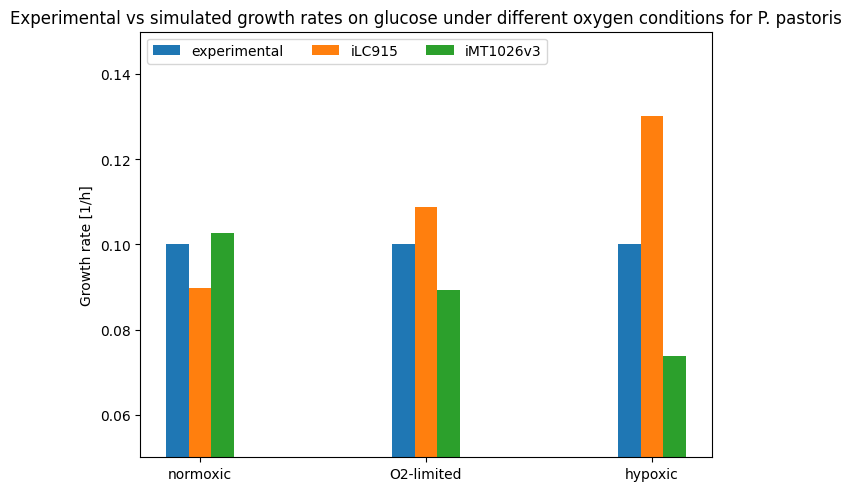

In [40]:
# plot experimental vs simulated growth rates
title = 'Experimental vs simulated growth rates on glucose under different oxygen conditions for P. pastoris'
y_label = 'Growth rate [1/h]'
outpath = ""
if _plotting:
    outpath = '../results/FBA_results/ppa_GEM_comparison/glucose_growth_comparison.png'
hf.plot_multiple_conditions(_growth_conditions, _condition_names, title, y_label, outpath, min_value = 0.05, max_value = 0.15)

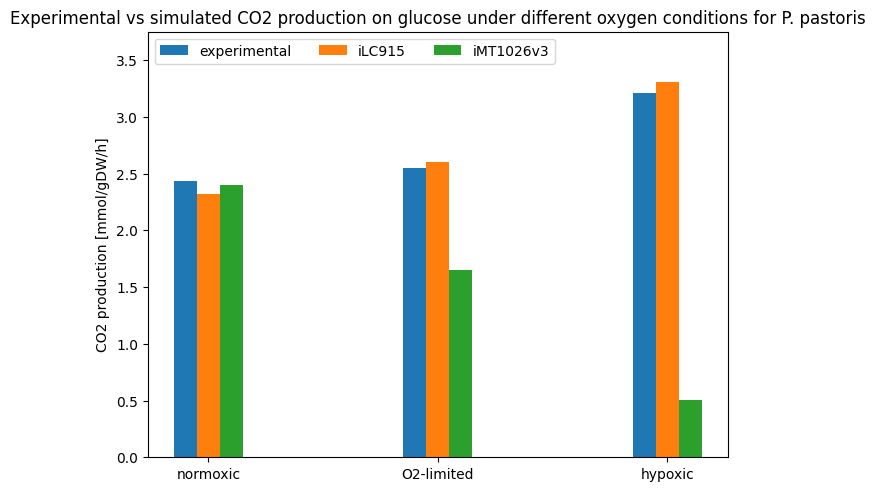

In [41]:
# plot experimental vs simulated co2 production
title = 'Experimental vs simulated CO2 production on glucose under different oxygen conditions for P. pastoris'
y_label = 'CO2 production [mmol/gDW/h]'
outpath = ""
if _plotting:
    outpath = '../results/FBA_results/ppa_GEM_comparison/CO2_production_with_iMT1026v1.png'
    if _without_iMT1026v1:
        outpath = '../results/FBA_results/ppa_GEM_comparison/CO2_production_without_iMT1026v1.png'
    
hf.plot_multiple_conditions(_co2_productions, _condition_names, title, y_label, outpath, min_value = 0, max_value = 3.75)